In [1]:
import pandas as pd
import nltk
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/Users/rwilkening/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('./Datasets/big_df.csv')

### Road Closure Classification

In [3]:
df.head(5)

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users,query
0,EPCFIRM,EPCF #GreenNewDeal #SunriseMovement,836834627771850752,1188564512669962240,/EPCFIRM/status/1188564512669962240,2019-10-27 21:13:56,1572210836,Our hearts go out to Californians affected by ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,['https://pbs.twimg.com/media/EH6hH4FVAAA6ZA_....,NaN,8,1,1,True,False,NaN,[],saddleridgefire
1,jsingpubhealth,Jason Singson,3320904614,1188545671076298752,/jsingpubhealth/status/1188545671076298752,2019-10-27 19:59:04,1572206344,"From the #SaddleridgeFire to the #KincadeFire,...","<p class=""TweetTextSize js-tweet-text tweet-te...",['https://twitter.com/CAgovernor/status/118852...,...,[],NaN,1,0,0,False,False,NaN,[],saddleridgefire
2,BrandyCGrote,Brandy Grote,898902973,1188517925503635456,/BrandyCGrote/status/1188517925503635456,2019-10-27 18:08:49,1572199729,Our #SaddleridgeFire leaped a 12 lane major fr...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,[],NaN,1,1,0,False,True,1.188496e+18,"[{'screen_name': 'BillMendocino', 'user_id': '...",saddleridgefire
3,mlzema,Mark In SoCal,18340526,1188515108562931714,/mlzema/status/1188515108562931714,2019-10-27 17:57:38,1572199058,"Good Morning, Sam!\nAll is well here. However,...","<p class=""TweetTextSize js-tweet-text tweet-te...",['https://twitter.com/Sam17970863/status/11885...,...,[],NaN,1,0,0,False,False,NaN,[],saddleridgefire
4,LVTIA,LVTIA,87142711,1188502337867829248,/LVTIA/status/1188502337867829248,2019-10-27 17:06:53,1572196013,Was your property or home damaged by the #Sadd...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.211la.org/fire-saddleridge'],...,[],NaN,0,0,0,False,False,NaN,[],saddleridgefire


In [4]:
df.columns

Index(['screen_name', 'username', 'user_id', 'tweet_id', 'tweet_url',
       'timestamp', 'timestamp_epochs', 'text', 'text_html', 'links',
       'hashtags', 'has_media', 'img_urls', 'video_url', 'likes', 'retweets',
       'replies', 'is_replied', 'is_reply_to', 'parent_tweet_id',
       'reply_to_users', 'query'],
      dtype='object')

### Viewing the query's with the most results

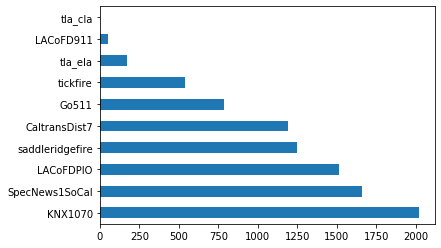

In [34]:
df['query'].value_counts().plot(kind='barh');

In [35]:
df.describe()

,user_id,tweet_id,timestamp_epochs,video_url,likes,retweets,replies,parent_tweet_id
count,9.180000e+03,9.180000e+03,9.180000e+03,0.0,9180.000000,9180.000000,9180.000000,3.591000e+03
mean,2.480952e+17,1.186864e+18,1.571805e+09,NaN,6.794336,2.592484,0.499891,1.186442e+18
std,4.284319e+17,2.723822e+15,6.494099e+05,NaN,55.376397,17.358898,5.527309,1.150514e+16
min,7.670000e+02,1.182083e+18,1.570666e+09,NaN,0.000000,0.000000,0.000000,7.278913e+17
25%,3.700991e+07,1.184353e+18,1.571207e+09,NaN,0.000000,0.000000,0.000000,1.184519e+18
50%,4.977324e+08,1.187003e+18,1.571839e+09,NaN,1.000000,0.000000,0.000000,1.187470e+18
75%,7.371190e+17,1.189245e+18,1.572373e+09,NaN,3.000000,1.000000,0.000000,1.189576e+18
max,1.190704e+18,1.191868e+18,1.572998e+09,NaN,2940.000000,747.000000,356.000000,1.191864e+18


#### Viewing a Sample of the text column

In [36]:
df['text']

0       Our hearts go out to Californians affected by ...
1       From the #SaddleridgeFire to the #KincadeFire,...
2       Our #SaddleridgeFire leaped a 12 lane major fr...
3       Good Morning, Sam!\nAll is well here. However,...
4       Was your property or home damaged by the #Sadd...
                              ...                        
9175    Former state lawmaker says he's got a plan to ...
9176               Totally makes sense to do this midday 
9177    A Sanford, Maine mom says her 9-year-old birac...
9178       I noticed it in Anaheim Hills, it looks crazy!
9179    The copyright owners of the "Charlie Brown Chr...
Name: text, Length: 9180, dtype: object

In [45]:
## Drop unnecessary columns 
df_text_query = df.drop(columns= ['screen_name', 'user_id', 'tweet_id', 'tweet_url', 'timestamp', 'timestamp_epochs', 'text_html', 'links', 'has_media', 'img_urls', 'video_url', 'likes', 'retweets', 'replies', 'is_replied', 'is_reply_to', 'parent_tweet_id', 'reply_to_users'])

### Check for Null Values

In [46]:
df_text_query.isnull().sum()

username      0
text        105
hashtags      0
query         0
dtype: int64

In [47]:
df_text_query.dropna(axis=0, how='any', inplace=True)

In [48]:
df_text_query.head()

,username,text,hashtags,query
0,EPCF #GreenNewDeal #SunriseMovement,Our hearts go out to Californians affected by ...,"['wildfires', 'ClimateChange', 'ClimateCrisis'...",saddleridgefire
1,Jason Singson,"From the #SaddleridgeFire to the #KincadeFire,...","['SaddleridgeFire', 'KincadeFire']",saddleridgefire
2,Brandy Grote,Our #SaddleridgeFire leaped a 12 lane major fr...,['SaddleridgeFire'],saddleridgefire
3,Mark In SoCal,"Good Morning, Sam!\nAll is well here. However,...",['SaddleridgeFire'],saddleridgefire
4,LVTIA,Was your property or home damaged by the #Sadd...,['SaddleRidgeFire'],saddleridgefire


In [49]:
df_text_query.isnull().sum()

username    0
text        0
hashtags    0
query       0
dtype: int64

In [50]:
df_text_query.shape

(9075, 4)

### Cleaning Tweets using RegEx

In [51]:
## Lower case texts
df_text_query['text'] = df_text_query['text'].str.lower()

In [52]:
## Removing line breaks
df_text_query['text'] = df_text_query['text'].map(lambda x: re.sub('\/\/', ' ', x)) 

In [53]:
## Removing Apostrophes
df_text_query['text'] = df_text_query['text'].map(lambda x: re.sub('[\\][\']', '', x))

In [54]:
## Removing URLs
df_text_query['text'] = df_text_query['text'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))

In [55]:
df_text_query.head(5)

,username,text,hashtags,query
0,EPCF #GreenNewDeal #SunriseMovement,our hearts go out to californians affected by ...,"['wildfires', 'ClimateChange', 'ClimateCrisis'...",saddleridgefire
1,Jason Singson,"from the #saddleridgefire to the #kincadefire,...","['SaddleridgeFire', 'KincadeFire']",saddleridgefire
2,Brandy Grote,our #saddleridgefire leaped a 12 lane major fr...,['SaddleridgeFire'],saddleridgefire
3,Mark In SoCal,"good morning, sam!\nall is well here. however,...",['SaddleridgeFire'],saddleridgefire
4,LVTIA,was your property or home damaged by the #sadd...,['SaddleRidgeFire'],saddleridgefire


### Road Closure Classification

#### We want to determine if a road was open or closed. We achieved this by passing our dataframe through the filters we created

In [56]:
# establish list of words to search for in dataframe
road_keywords = ['road', 'st','rd', 'hwy', 'highway', 'ave', 'avenue', 'street', 'boulevard'
                 'intersection', 'bridge', 'sr-', 'cr-', 'us-', 'i-', 'blvd']

# list of words associated with road closures
closed_keywords = ['closed', 'remains closed', 'shut down', 'backed up',
                   'no travel', 'delay', 'blocked', 'delays',
                   'disabled', 'traffic', 'fire', 'closures', 'closure']

to_drop = ["open", "opened", "lifted", "reopened", "clear", "cleared"]

In [57]:
df_text_query['is_road_closed']= df_text_query['text'].apply(lambda x: 1 if ((any(word in x.split() for word in road_keywords))
                                                           & (any(word in x.split() for word in closed_keywords))
                                                           & (not any(word in x.split() for word in to_drop))
                                                          ) else 0)

In [58]:
df_text_query.head()

,username,text,hashtags,query,is_road_closed
0,EPCF #GreenNewDeal #SunriseMovement,our hearts go out to californians affected by ...,"['wildfires', 'ClimateChange', 'ClimateCrisis'...",saddleridgefire,0
1,Jason Singson,"from the #saddleridgefire to the #kincadefire,...","['SaddleridgeFire', 'KincadeFire']",saddleridgefire,0
2,Brandy Grote,our #saddleridgefire leaped a 12 lane major fr...,['SaddleridgeFire'],saddleridgefire,0
3,Mark In SoCal,"good morning, sam!\nall is well here. however,...",['SaddleridgeFire'],saddleridgefire,0
4,LVTIA,was your property or home damaged by the #sadd...,['SaddleRidgeFire'],saddleridgefire,0


#### Baseline Comparison

In [59]:
df_text_query['is_road_closed'].value_counts()

0    8762
1     313
Name: is_road_closed, dtype: int64

In [60]:
df_text_query['is_road_closed'].value_counts(normalize = True)

0    0.96551
1    0.03449
Name: is_road_closed, dtype: float64

### Viewing the count of each column based on if the road if open or closed

In [61]:
df_text_query.groupby('is_road_closed').count()

,username,text,hashtags,query
is_road_closed,,,,
0,8762,8762,8762,8762
1,313,313,313,313


In [62]:
## assign road closed or open dataframes
closed_road = df_text_query[df_text_query['is_road_closed'] == 1]
open_road = df_text_query[df_text_query['is_road_closed'] == 0]

In [63]:
closed_road.shape

(313, 5)

In [64]:
closed_road.head()

,username,text,hashtags,query,is_road_closed
272,News Source LA,@dwp blocked san fernando rd during the #saddl...,['SaddleRidgeFire'],saddleridgefire,1
281,News Source LA,we had the same thing from @dwp security on sa...,['SaddleRidgeFire'],saddleridgefire,1
502,Donald Lindsay,oh noes. #realfire in santa barbara co may hav...,"['RealFire', 'CalFire', 'SaddleRidgeFire']",saddleridgefire,1
620,Allison McHaney,today across the street from olive vista middl...,"['RedCross', 'Sylmar', 'SaddleridgeFire', 'Syl...",saddleridgefire,1
637,Allison McHaney,today across the street from olive vista middl...,"['RedCross', 'Sylmar', 'SaddleridgeFire', 'Syl...",saddleridgefire,1


In [65]:
open_road.shape

(8762, 5)

#### Viewing the hashtags for closed_roads

In [77]:
closed_road['hashtags']

272                                   ['SaddleRidgeFire']
281                                   ['SaddleRidgeFire']
502            ['RealFire', 'CalFire', 'SaddleRidgeFire']
620     ['RedCross', 'Sylmar', 'SaddleridgeFire', 'Syl...
637     ['RedCross', 'Sylmar', 'SaddleridgeFire', 'Syl...
                              ...                        
9132           ['118Fwy', 'LATraffic', 'KNXTraffichttps']
9138                         ['SigAlert', 'Fire', 'wind']
9145    ['118Fwy', 'SimiValley', 'LATraffic', 'KNXTraf...
9152           ['118Fwy', 'LATraffic', 'KNXTraffichttps']
9158                         ['SigAlert', 'Fire', 'wind']
Name: hashtags, Length: 313, dtype: object

#### Viewing the hashtags for open roads

In [78]:
open_road['hashtags']

0       ['wildfires', 'ClimateChange', 'ClimateCrisis'...
1                      ['SaddleridgeFire', 'KincadeFire']
2                                     ['SaddleridgeFire']
3                                     ['SaddleridgeFire']
4                                     ['SaddleRidgeFire']
                              ...                        
9175                                                   []
9176                                                   []
9177                                                   []
9178                                                   []
9179                                                   []
Name: hashtags, Length: 8762, dtype: object

#### Which handles tweeted the mode about road closures

In [66]:
# find which handles tweeted the most about road closures
closed_road['username'].value_counts().iloc()[0:7]

Go511                  139
Caltrans District 7     56
Brian Douglas           19
scott burt              12
Desmond Shaw            11
KNX 1070 NEWSRADIO       6
Belen De Leon            3
Name: username, dtype: int64

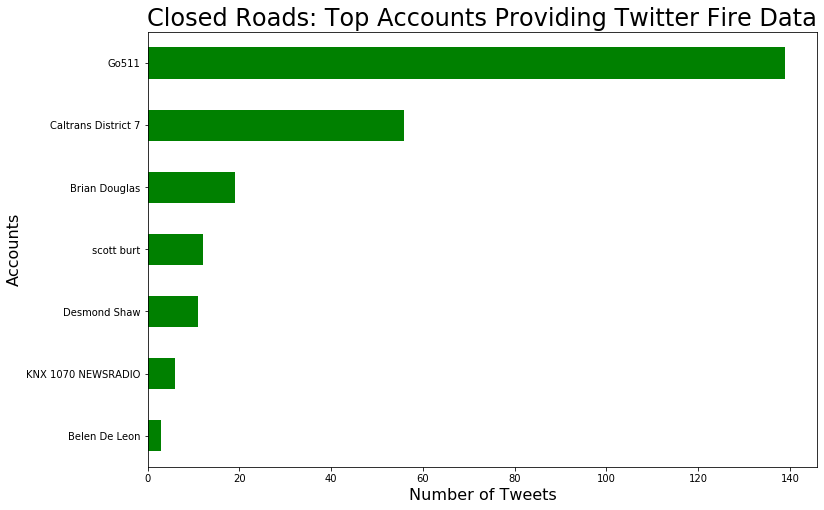

In [67]:
plt.figure(figsize=(12, 8))
closed_road['username'].value_counts(ascending=True).tail(7).plot(kind='barh', color='g')
plt.title("Closed Roads: Top Accounts Providing Twitter Fire Data", fontsize = 24)
plt.xlabel("Number of Tweets", fontsize=16)
plt.ylabel("Accounts", fontsize=16)
plt.savefig('./Assets/top_accounts.png');

In [68]:
closed_road.shape

(313, 5)

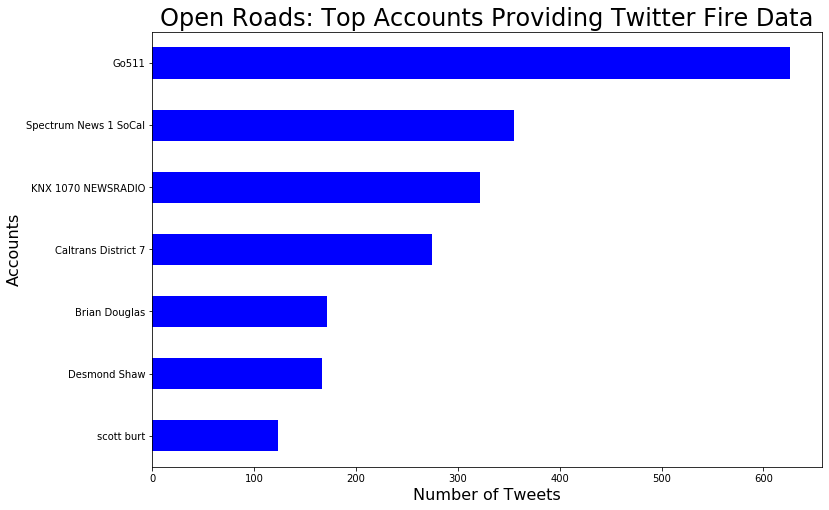

In [69]:
plt.figure(figsize=(12, 8))
open_road['username'].value_counts(ascending=True).tail(7).plot(kind='barh', color='b')
plt.title("Open Roads: Top Accounts Providing Twitter Fire Data", fontsize = 24)
plt.xlabel("Number of Tweets", fontsize=16)
plt.ylabel("Accounts", fontsize=16)
plt.savefig('./Assets/top_accounts.png');

### Declaring a Tokenizer Function:

In [70]:
tokenizer = RegexpTokenizer(r'\s+', gaps=True)

def tokenizing_function(df_col):

    string = ''
    
    try:
    
        for post in df_col:
            string += ' ' + post
            
    except:
        pass
    
    all_tokens = tokenizer.tokenize(string)
    
    return all_tokens

### Calling Tokenizer Function on `text` Column and Saving as Variable

In [71]:
text_tokens = tokenizing_function(df['text'])

### Declaring Count Vectorizer Function:

In [72]:
cvec = CountVectorizer(stop_words= 'english', min_df=5)

def cvec_function(df_col):
    cvec_matrix = cvec.fit_transform(df_col)

    #Convert to DataFrame
    cvec_df = pd.DataFrame(cvec_matrix.toarray(),
                          columns=cvec.get_feature_names())
    return cvec_df

### Calling the cvec_function with `text` column and saving the matrix as `text_cvec_df` variable

In [73]:
hash_cvec_df = cvec_function(df['hashtags'])
hash_cvec_df

,101fwy,105fwy,10fwy,110fwy,118fwy,134fwy,14freeway,14fwy,1582,15fwy,...,westhollywood,westla,wevapewevote,wildfire,wildfirepic,wildfires,wolffire,woodlandhills,woolseyfire,yeswx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Viewing Top 50 Words in `text` column:

In [74]:
hash_cvec_df.sum().sort_values(ascending=False).head(50)

saddleridgefire        1390
tickfire                777
knxtraffic              377
latraffic               285
gettyfire               218
kincadefire             189
californiafires         112
easyfire                111
losangeles              101
rt                       96
sigalert                 94
knxtrafficpic            90
california               90
wildfires                81
5fwy                     76
santaclarita             72
sylmar                   71
lacofd                   67
palisadesfire            64
porterranch              63
ca25                     59
wildfire                 58
405fwy                   58
101fwy                   56
lafd                     53
firefighters             52
californiawildfires      50
pulsepointconnected      49
60fwy                    42
605fwy                   42
saddleridge              42
110fwy                   41
sandalwoodfire           39
kincaidfire              39
oakfire                  38
oldwaterfire        

### Exporting as CSV for Modeling

In [79]:
df_text_query.to_csv('./Datasets/modeling_csv')